In [17]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
plt.style.use("dark_background")
plt.rcParams['figure.figsize']=(15,6)
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import expected_returns, risk_models
from pypfopt.risk_models import sample_cov
from pypfopt import plotting
from pypfopt.objective_functions import L2_reg
import warnings
warnings.filterwarnings('ignore')

In [18]:
# Importing prices data
tickers = ['AAPL', 'AMD', 'GOOG', 'META', 'MSFT', 'AMZN', 'NVDA', 'TSLA', 'NFLX', 'ADBE']
start_date = '2022-11-05'
end_date = '2024-11-05'
# Downloading data from YF
data = yf.download(tickers = tickers, start = start_date, end = end_date)
# Retrieve the 'Adj Close' column
# Takes into consideration dividends, stock splits.
prices = data['Adj Close']
# Setting 'Date' as the index
prices = pd.DataFrame(prices)
prices.reset_index(inplace = True)
prices.set_index('Date', inplace = True)

[*********************100%***********************]  10 of 10 completed


In [19]:
returns = np.log(prices / prices.shift(1))
returns

,AAPL,ADBE,AMD,AMZN,GOOG,META,MSFT,NFLX,NVDA,TSLA
Date,,,,,,,,,,
2022-11-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-11-08,0.004167,0.008742,0.012133,-0.006094,0.002929,-0.002588,0.004379,0.018619,0.020829,-0.029767
2022-11-09,-0.033754,-0.010981,-0.063526,-0.043614,-0.017129,0.050531,-0.019234,-0.033972,-0.058231,-0.074365
2022-11-10,0.085236,0.098932,0.133385,0.114915,0.074606,0.097574,0.079059,0.076733,0.133912,0.071329
2022-11-11,0.019085,0.033381,0.055396,0.042150,0.026822,0.010227,0.016854,0.053667,0.035980,0.027155
...,...,...,...,...,...,...,...,...,...,...
2024-10-29,0.001156,0.009002,0.038819,0.012869,0.016496,0.025816,0.012487,0.013682,0.005182,-0.011455
2024-10-30,-0.015396,0.002654,-0.112235,0.009907,0.028797,-0.002498,0.001342,-0.007534,-0.013614,-0.007620
2024-10-31,-0.018377,-0.017829,-0.030959,-0.033395,-0.019781,-0.041787,-0.062437,0.003034,-0.048374,-0.030353


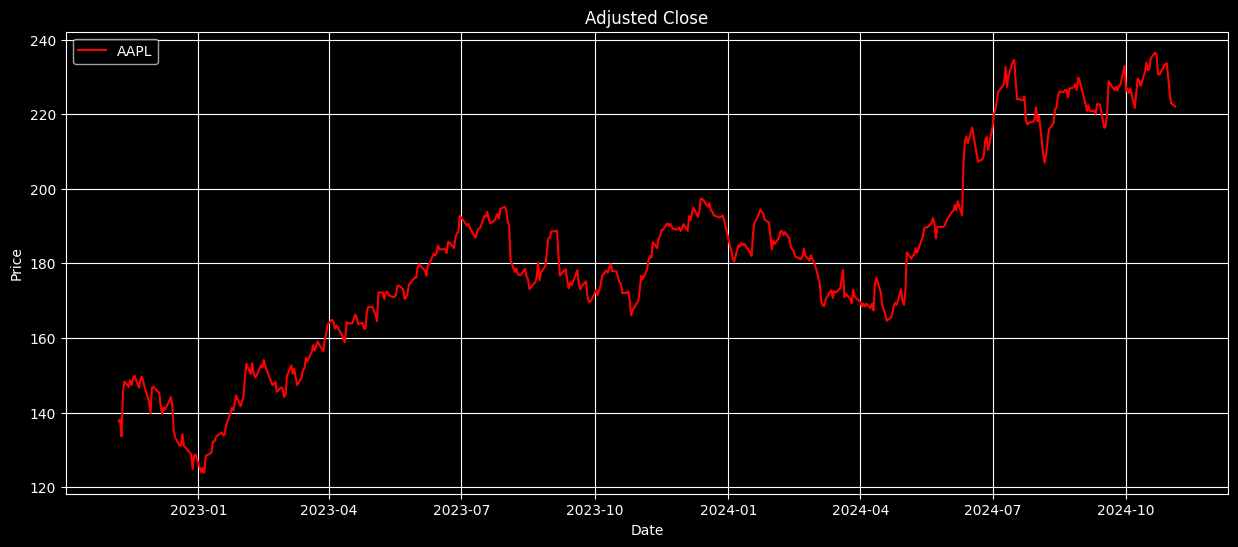

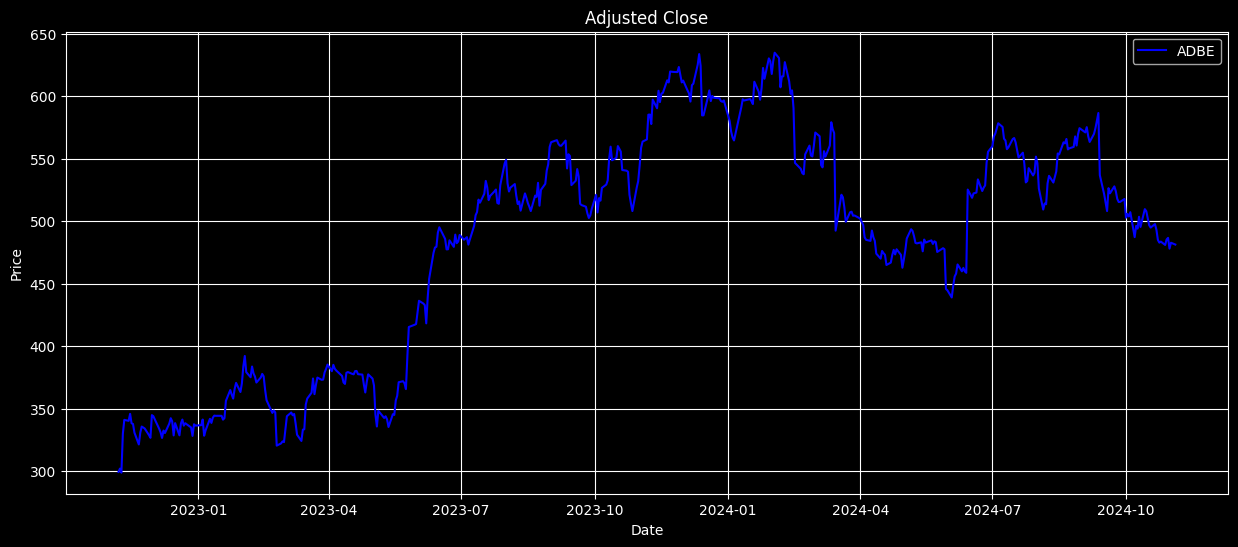

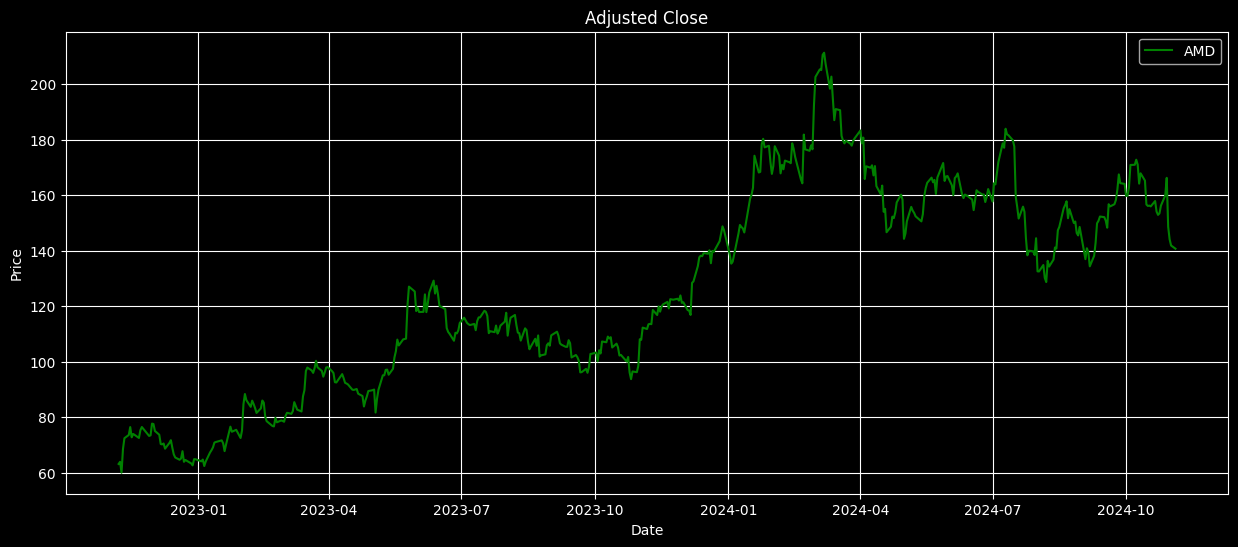

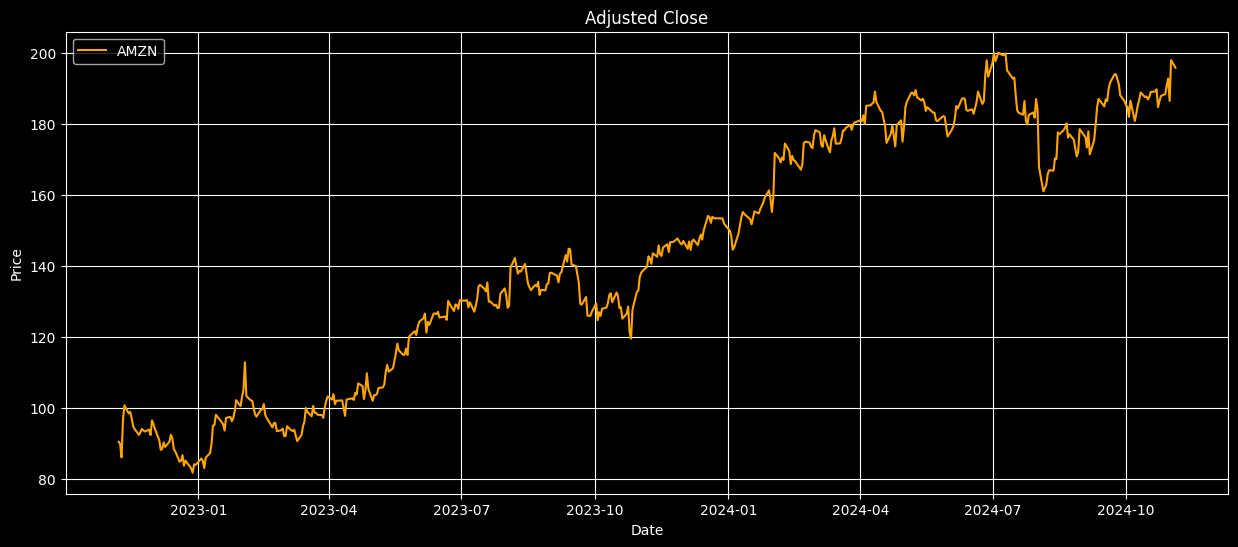

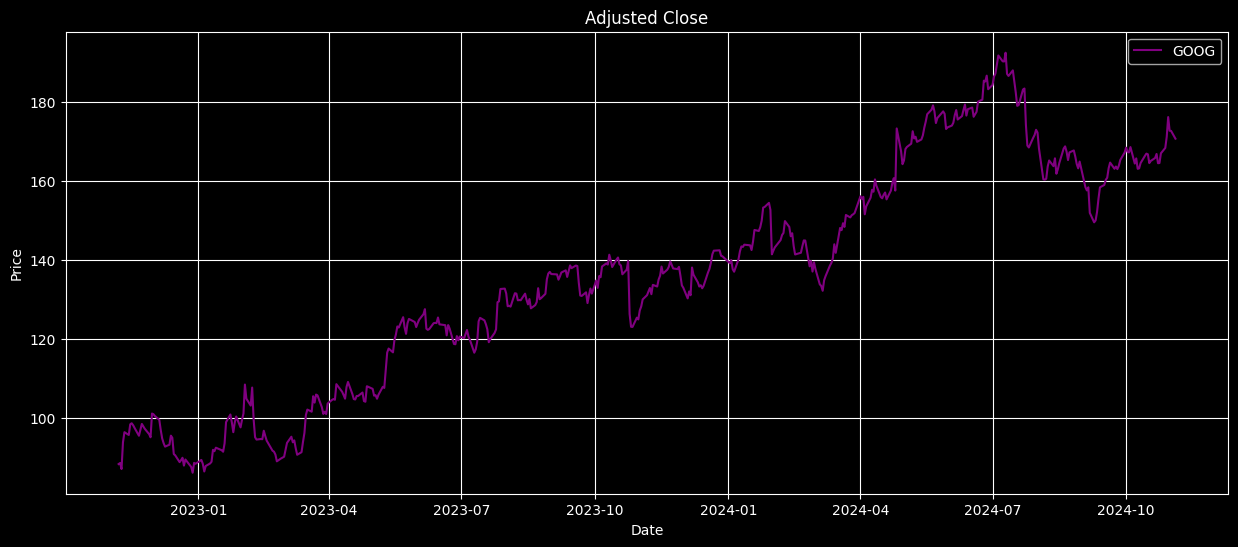

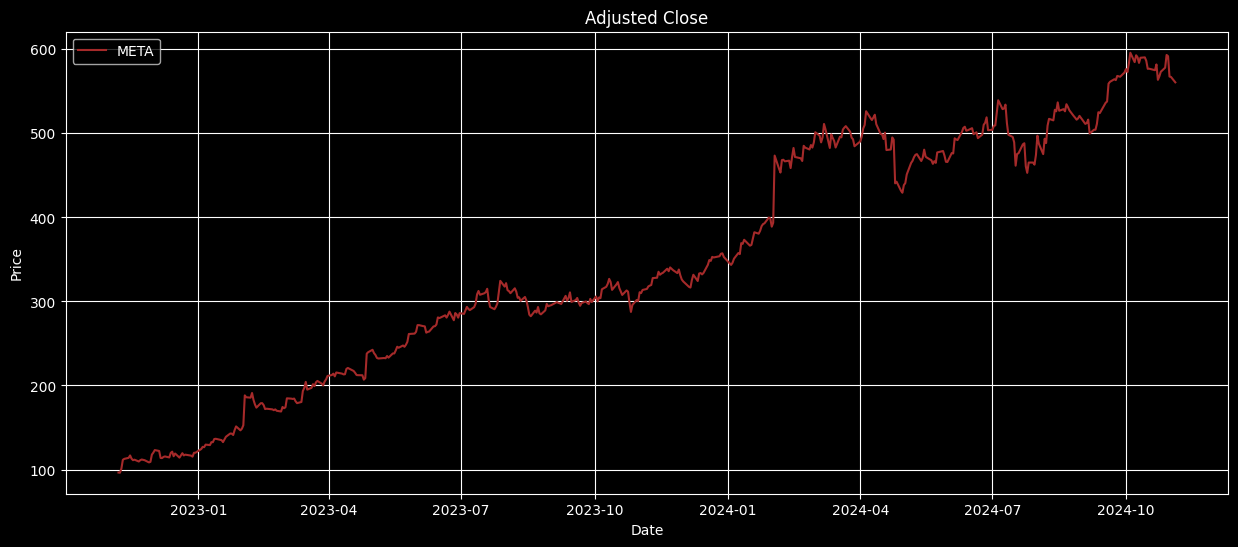

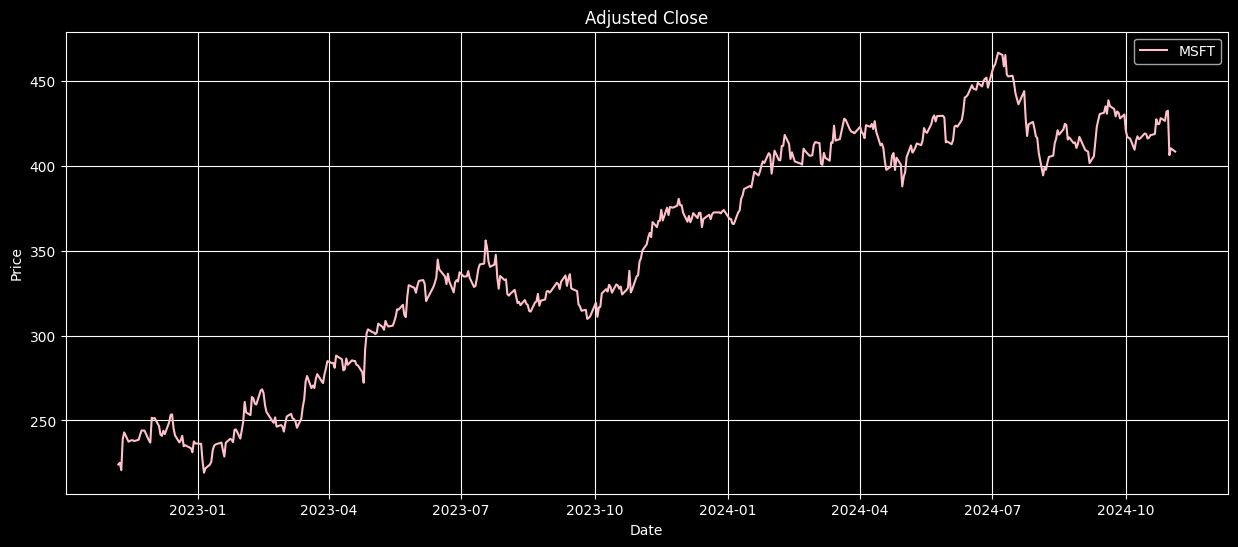

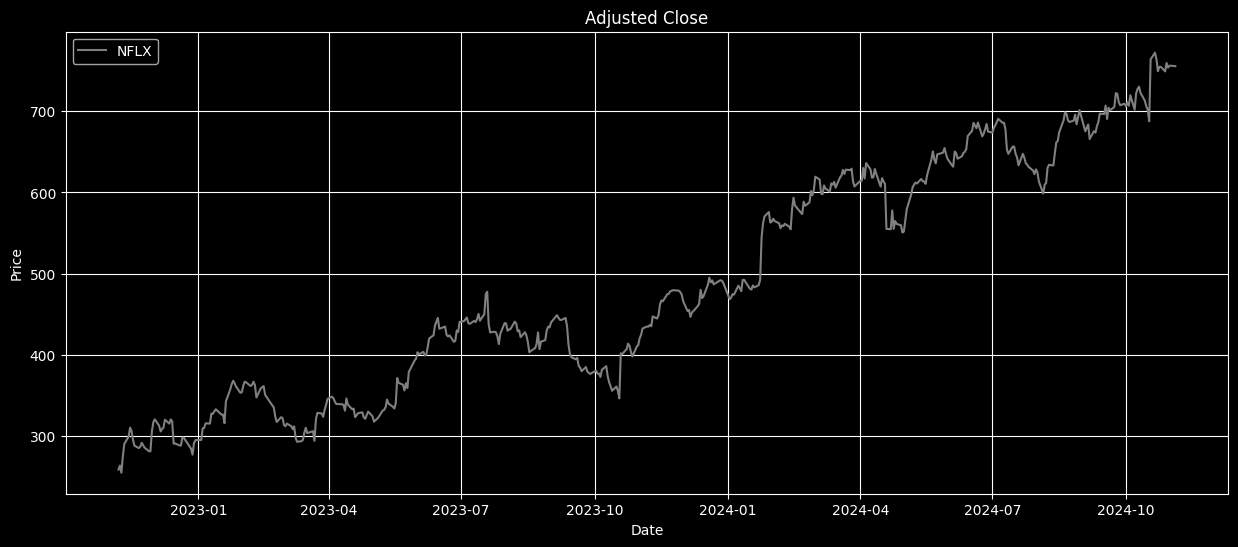

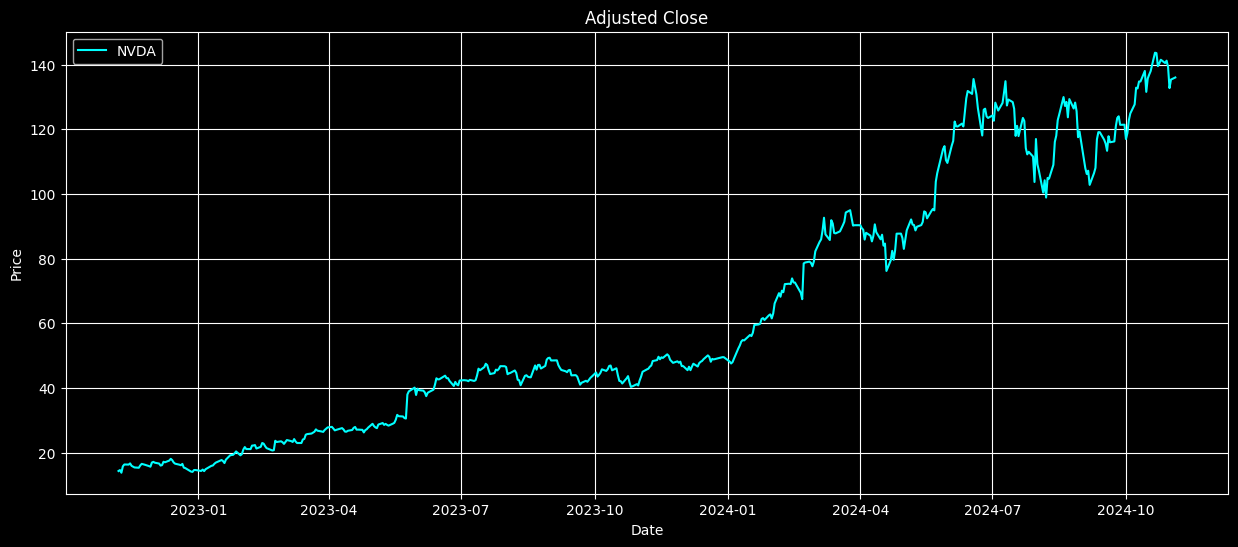

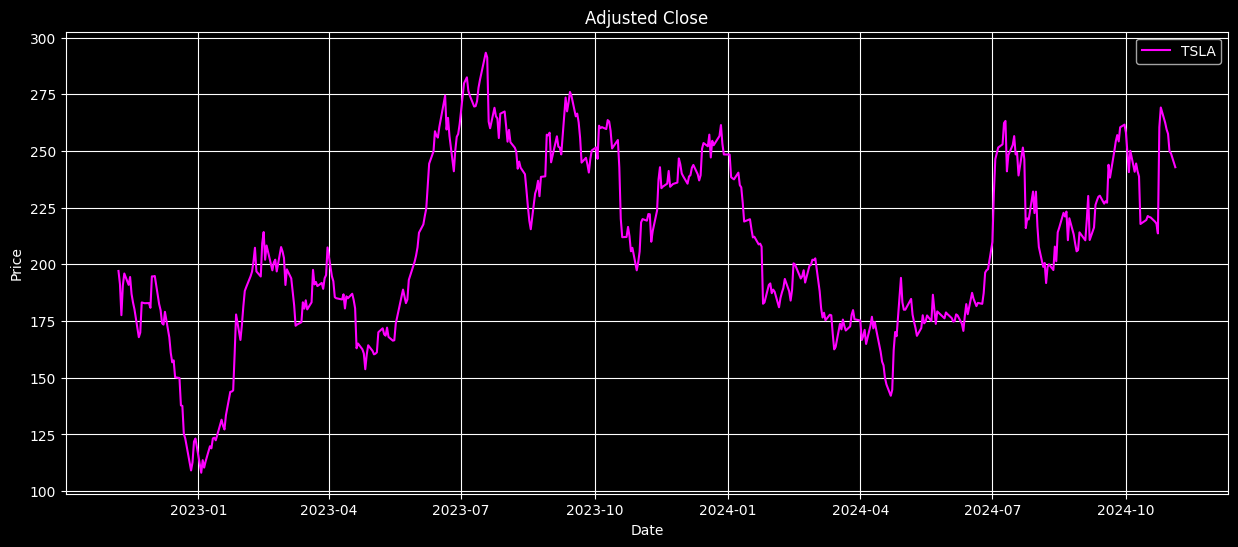

In [20]:
# Set the figure size
plt.figure(figsize=(15, 6))
colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'cyan', 'magenta']
for i, column in enumerate(prices.columns):
  plt.plot(prices.index, prices[column], label=column, color = colors[i])
  plt.title('Adjusted Close')
  plt.xlabel('Date')
  plt.ylabel('Price')
  plt.legend()
  plt.grid(True)
  plt.savefig("prices.png", dpi=200)
  plt.grid(True)
  plt.show()

In [21]:
weights = np.array([0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1])

In [22]:
mu = expected_returns.mean_historical_return(prices, compounding=True, frequency=252)

In [23]:
S = sample_cov(prices, frequency=252)

In [24]:
port_annual_ret = np.sum(returns.mean() * weights) * 252
port_annual_ret

0.4575939681745963

In [25]:
port_variance = np.dot(weights.T, np.dot(S, weights))
port_variance

0.07130107234422378

In [26]:
port_volatility = np.sqrt(port_variance)
port_volatility

0.2670226064291632

In [27]:
#Risk free rate = 4.5%
risk_free_rate = 0.045
sharpe_ratio = str(round((port_annual_ret - risk_free_rate)/port_volatility, 3))
# Performance of initial portfolio with 10% allocation for each Stock
percent_ret = str(round(port_annual_ret, 2)*100) + '%'
percent_vol = str(round(port_volatility, 2)*100) + '%'
percent_var = str(round(port_variance, 2)*100) + '%'
print ('Expected annual return :' + percent_ret)
print ('Annual Volatility / Risk :' + percent_vol)
print ('Annual Variance :' + percent_var)
print ('Sharpe Ratio :' + sharpe_ratio)

Expected annual return :46.0%
Annual Volatility / Risk :27.0%
Annual Variance :7.000000000000001%
Sharpe Ratio :1.545


In [28]:
# Minimum Volatility Portfolio
ef = EfficientFrontier(mu, S)
weights = ef.min_volatility()
cleaned_min_vol = ef.clean_weights()
print(cleaned_min_vol)
ef.portfolio_performance(verbose=True, risk_free_rate=0.045)

OrderedDict([('AAPL', 0.44658), ('ADBE', 0.03091), ('AMD', 0.0), ('AMZN', 0.0), ('GOOG', 0.09158), ('META', 0.0), ('MSFT', 0.37403), ('NFLX', 0.05689), ('NVDA', 0.0), ('TSLA', 0.0)])
Expected annual return: 33.9%
Annual volatility: 20.8%
Sharpe Ratio: 1.41


(0.33906134502397633, 0.20839113260444717, 1.4111029646455358)

In [29]:
#Maximum Sharpe ratio with NO Constraints
ef = EfficientFrontier(mu, S)
weights = ef.max_sharpe(risk_free_rate=0.05)
cleaned_no_const = ef.clean_weights()
print(cleaned_no_const)
ef.portfolio_performance(verbose=True, risk_free_rate=0.045)

OrderedDict([('AAPL', 0.0), ('ADBE', 0.0), ('AMD', 0.0), ('AMZN', 0.0), ('GOOG', 0.0), ('META', 0.48883), ('MSFT', 0.0), ('NFLX', 0.0), ('NVDA', 0.51117), ('TSLA', 0.0)])
Expected annual return: 177.9%
Annual volatility: 39.4%
Sharpe Ratio: 4.39


(1.7786843888183743, 0.39408812779611724, 4.3865426712694955)

In [30]:
# Max Sharpe Ratio with constraints :
# 1) All weights should add up to 1
# 2) No shorting is allowed
# 3) L2_regularization in order to reduce the zero weights
ef = EfficientFrontier(mu, S)
ef.add_objective(L2_reg, gamma=2)
ef.add_constraint(lambda w : w[0] + w[1] + w[2] + w[3] + w[4] + w[5] + w[6] + w[7] + w[8] + w[9] == 1)
ef.add_constraint(lambda w : w >= 0)
weights = ef.max_sharpe(risk_free_rate=0.05)
cleaned_L2_reg = ef.clean_weights()
print(cleaned_L2_reg)
ef.portfolio_performance(verbose=False, risk_free_rate=0.045)

OrderedDict([('AAPL', 0.02808), ('ADBE', 0.01694), ('AMD', 0.04169), ('AMZN', 0.05984), ('GOOG', 0.04734), ('META', 0.26308), ('MSFT', 0.04014), ('NFLX', 0.11575), ('NVDA', 0.38714), ('TSLA', 0.0)])


(1.3712460949669532, 0.33614524100858256, 3.9305809923193844)

- Performance of the portfolio that minimizes volatility :
Expected annual return: 33.9%
Annual volatility: 20.8%
Sharpe Ratio: 1.41
- Performance of the unconstrained portfolio that maximizes Sharpe ratio :
Expected annual return: 177.9%
Annual volatility: 39.4%
Sharpe Ratio: 4.39
- Performance of the portfolio that maximizes Sharpe ratio, with L2 regularization :
Expected annual return: 136.6%
Annual volatility: 33.5%
Sharpe Ratio: 3.94


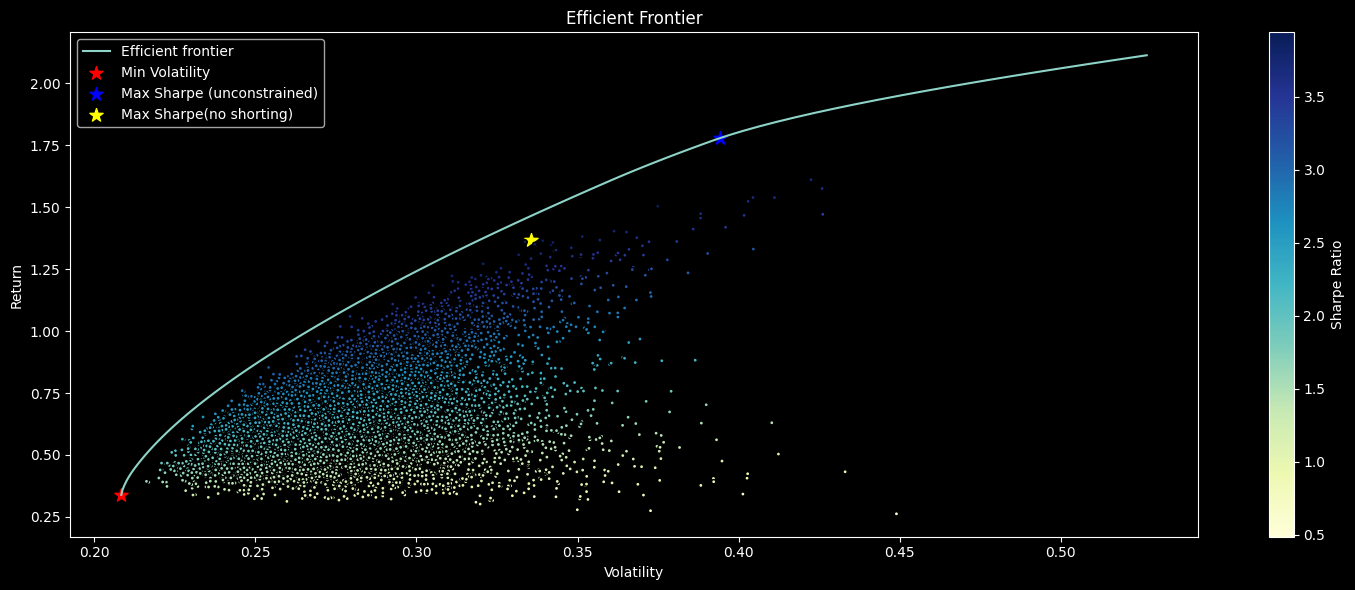

In [31]:
# Define the EfficientFrontier object
ef = EfficientFrontier(mu, S)
ef_constr = EfficientFrontier(mu, S, weight_bounds=(0,1))
# Portfolio that minimizes volatility
ef_min_volatility = ef.deepcopy()
weights_min_volatility = ef_min_volatility.min_volatility()
print("- Performance of the portfolio that minimizes volatility :")
ef_min_volatility.portfolio_performance(verbose=True, risk_free_rate=risk_free_rate)
# Portfolio with no constraints !!!
ef_no_const = ef.deepcopy()
weights_no_const = ef_no_const.max_sharpe(risk_free_rate=0.05)
print("- Performance of the unconstrained portfolio that maximizes Sharpe ratio :")
ef_no_const.portfolio_performance(verbose=True)
# Portfolio that maximizes Sharpe ratio with no shorting allowed + L2 regularization
ef_no_shorting = ef_constr.deepcopy()
ef_no_shorting.add_objective(L2_reg, gamma=2)
ef_no_shorting.add_constraint(lambda w : w[0] + w[1] + w[2] + w[3] + w[4] + w[5] + w[6] + w[7] + w[8] + w[9] == 1)
ef_no_shorting.add_constraint(lambda w : w >= 0)
weights_no_shorting = ef_no_shorting.max_sharpe(risk_free_rate=risk_free_rate)
print("- Performance of the portfolio that maximizes Sharpe ratio, with L2 regularization :")
ef_no_shorting.portfolio_performance(verbose=True)
# Plot the efficient frontier with the portfolios
fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=False)
# Plot the portfolio that minimizes volatility
ret_vol, std_vol, _ = ef_min_volatility.portfolio_performance()
ax.scatter(std_vol, ret_vol, marker="*", s=100, c="r", label="Min Volatility")
# Plot the portfolio with no constraints
ret_no_const, std_no_const, _ = ef_no_const.portfolio_performance()
ax.scatter(std_no_const, ret_no_const, marker="*", s=100, c="blue", label="Max Sharpe (unconstrained)")
# Plot the portfolio that maximizes Sharpe ratio with no shorting allowed
ret_shorting, std_shorting, _ = ef_no_shorting.portfolio_performance()
ax.scatter(std_shorting, ret_shorting, marker="*", s=100, c="Yellow", label="Max Sharpe(no shorting)")
# Generate random portfolios
n_samples = 10000
w_random = np.random.dirichlet(np.ones(ef.n_assets), n_samples)
rets_random = w_random.dot(ef.expected_returns)
stds_random = np.sqrt(np.diag(w_random @ ef.cov_matrix @ w_random.T))
sharpes_random = (rets_random - risk_free_rate) / stds_random
sc = ax.scatter(stds_random, rets_random, marker=".", c=sharpes_random, edgecolors="black" , cmap="YlGnBu")
# Output
cbar = plt.colorbar(sc)
cbar.set_label('Sharpe Ratio')
ax.set_title("Efficient Frontier")
ax.legend()
plt.tight_layout()
plt.savefig("ef_scatter.png", dpi=200)
plt.show()